# Обучение моделей position selector

В этом нотбуке будет произведен сбор обучающей выборки и обучение position selector с использованием дополнительных признаков.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import sys
import os
import json
import pickle
import re
from copy import copy, deepcopy
from collections import defaultdict
from string import punctuation
sys.path.append('..')

import dotenv
import numpy as np
import pandas as pd
from transformers import BertForMaskedLM, BertTokenizer, BertConfig

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

import kenlm
from sacremoses import MosesTokenizer, MosesDetokenizer

from src.models.SpellChecker import *
from src.models.BertScorer.bert_scorer_correction import (
    BertScorerCorrection
)
from src.evaluation.spell_ru_eval import align_sents

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import (
    KFold, cross_validate, cross_val_score, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score, recall_score, fbeta_score, make_scorer
)
from sklearn.utils.class_weight import compute_class_weight

import catboost
from catboost import CatBoostClassifier, Pool

import graphviz
from IPython.display import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

[nltk_data] Downloading package punkt to /home/mrgeekman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrgeekman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/mrgeekman/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/mrgeekman/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


In [3]:
PROJECT_PATH = os.path.join(os.path.abspath(''), os.pardir)
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')

## Нахождение корректных токенов

Начнем с того, что найдем какие токены в каждой позиции правильные. Так как наша модель не умеет никак объединять токены надо будет найти те предложения, где токены исходного предложения не объединяются.

Создадим токенизаторы.

In [4]:
raw_tokenizer = MosesTokenizer(lang='ru')
raw_detokenizer = MosesDetokenizer(lang='ru')
tokenizer = lambda x: raw_tokenizer.tokenize(x, escape=False)
detokenizer = lambda x: raw_detokenizer.detokenize(x)

Прочитаем все предложения.

In [5]:
with open(
    os.path.join(DATA_PATH, 'external', 'spell_ru_eval', 'train_source.txt'), 
    'r'
) as inf:
    sentences = inf.readlines()
    
with open(
    os.path.join(DATA_PATH, 'external', 'spell_ru_eval', 
                 'train_corrected.txt'), 
    'r'
) as inf:
    sentences_corrected = inf.readlines()

Теперь такое надо сделать со всеми предложениями в датасете, но надо учесть, что иногда нам могут встречаться случаи, когда нескольким токенам слева соответствует один токен справа (например, когда в слове случайно вставлен пробел). Это случай более слоный с точки зрения обработки, а потому будем игнорировать такие предложения.

In [11]:
def find_correction_positions(sentence, sentence_corrected):
    """Find position for correction in sentence."""
    tokenized_sentence_raw = tokenizer(
        sentence.lower().replace('ё', 'е')
    )
    tokenized_sentence_corrected = tokenizer(
        sentence_corrected.lower().replace('ё', 'е')
    )
    # remove punctuation from source sentence and make mapping 
    # to initial indices
    tokenized_sentence = []
    indices_mapping = []
    for i, token in enumerate(tokenized_sentence_raw):
        if not re.fullmatch(f'[{punctuation}]+', token):
            tokenized_sentence.append(token)
            indices_mapping.append(i)
    
    alignment = align_sents(tokenized_sentence, tokenized_sentence_corrected)
    
    answer = {}
    for i, pair in enumerate(alignment):
        left_indices, right_indices = pair
        if left_indices[1] - left_indices[0] > 1:
            return None
        
        answer[indices_mapping[left_indices[0]]] = (
            tokenized_sentence[left_indices[0]]
            != detokenizer(
                 tokenized_sentence_corrected[
                     right_indices[0]:right_indices[1]]
            )
        )
    return answer

Выполняем действие над всеми предложениями в обучающем датасете.

In [12]:
succ_indices = []
answers = {}
for i, (sentence, sentence_corrected) in enumerate(
    zip(sentences, sentences_corrected)
):
    answer = find_correction_positions(sentence, sentence_corrected)
    if answer:
        succ_indices.append(i)
        answers[i] = answer
        
sentences_to_check = [sentences[idx] for idx in succ_indices]

Мы уже знаем по ноутбуку `6.0-db-learning_advanced_scorer`, что нам не удастся так обработать 70 предложений.

Посмотрим, как выглядит элемент выборки.

In [14]:
answers[0]

{0: False, 1: False, 2: False, 3: True, 4: False, 5: True, 6: False}

## Сбор обучающей выборки

Теперь требуется собрать саму обучающую выборку. 

Пусть на вход подается некоторое предложение для исправления. В процессе работы модели position selector находит позиции для исправления. Наша задача &mdash; зафиксировать признаки попавших в position selector кандидатов.

Такое сохранение будет сделано при помощи callback-функции после вызова candidate scorer. Она соберет кандидатов с их признками и запишет это в файл. Можно было бы реализовать сбор за счет введения дополнительной callback-функции после вызова position selector.

In [ ]:
data = {}

In [ ]:
def create_callback_position_selector(num_batch):
    def callback_position_selector(
        tokenized_sentences, indices_processing_sentences, 
        candidates, positions, 
        scoring_results, scoring_info
    ):
        for num_sent, candidates_sentence in enumerate(candidates):
            key = (num_batch, indices_processing_sentences[num_sent])
            for position, candidates_position in enumerate(candidates_sentence):    
                if key not in data:
                    data[key] = []
                data[key].append({
                    'position': position,
                    'candidates': deepcopy(candidates_position)
                })
    return callback_position_selector

Проинициализируем модель.

In [ ]:
vocab_path = os.path.join(DATA_PATH, 'external', 'russian_words', 
                          'russian_words_vocab.dict')
vocab = SimpleVocabulary(load_path=vocab_path, save_path=vocab_path)
handcode_table_path = os.path.join(DATA_PATH, 'processed', 'handcode_table', 
                                   'table.json')
with open(handcode_table_path, 'r') as inf:
    handcode_table = json.load(inf)
candidate_generator = CandidateGenerator(
    words=vocab.keys(), handcode_table=handcode_table, max_distance=1
)

Требуем, чтобы все кандидаты дошли до `callback`-функции.

In [ ]:
model_left_right = kenlm.LanguageModel(
    os.path.join(MODEL_PATH, 'kenlm', 'left_right_3_100.arpa.binary')
)
model_right_left = kenlm.LanguageModel(
    os.path.join(MODEL_PATH, 'kenlm', 'right_left_3_100.arpa.binary')
)
margin_border = np.log(0.9)
position_selector = KenlmMarginPositionSelector(
    model_left_right, model_right_left, margin_border=margin_border
)

In [ ]:
BERT_PATH = os.path.join(MODEL_PATH, 'conversational_rubert')
config = BertConfig.from_json_file(
    os.path.join(BERT_PATH, 'bert_config.json')
)
model = BertForMaskedLM.from_pretrained(
    os.path.join(BERT_PATH, 'pytorch_model.bin'),
    config=config
)
bert_tokenizer = BertTokenizer(os.path.join(BERT_PATH, 'vocab.txt'))
bert_scorer_correction = BertScorerCorrection(model, bert_tokenizer)
agg_subtoken_func = 'mean'
bert_scorer = BertScorer(
    bert_scorer_correction, agg_subtoken_func
)
candidate_scorer = CandidateScorer(bert_scorer)

Ставим число итераций, равное одному, так как нам потребуется лишь один вызов, чтобы собрать всю необходимую информацию о кандидатах.

In [ ]:
# максимальное количество итераций
max_it = 1

spellchecker = IterativeSpellChecker(
    candidate_generator,
    position_selector,
    candidate_scorer,
    tokenizer,
    detokenizer,
    max_it=max_it
)

Запустим сбор обучающей выборки.

In [ ]:
batch_size = 5
num_batches = int(np.ceil(len(sentences_to_check) / batch_size))

for i in tqdm(range(num_batches)):
    cur_sentences = sentences_to_check[i*batch_size:(i+1)*batch_size]
    spellchecker(
        cur_sentences,
        callback_candidate_scorer=create_callback_position_selector(i)
    )

Переведем текущие индексы предложений в исходные и сохраним данные на диск.

In [ ]:
data_adjusted = {}
for key, value in data.items():
    key_adjusted = succ_indices[key[0]*batch_size + key[1]]
    data_adjusted[key_adjusted] = value
    
data = data_adjusted

In [ ]:
data_with_answers = {}
for key, value in data.items():
    new_value = []
    for item in value:
        new_item = copy(item)
        if item['position'] in answers[key]:
            new_item['answer'] = answers[key][item['position']]
            new_value.append(new_item)
    data_with_answers[key] = new_value
    
data = data_with_answers

In [ ]:
!mkdir -p ../data/processed/position_selector

In [ ]:
with open(os.path.join(DATA_PATH, 'processed', 'position_selector', 'data.bin'), 'wb') as ouf:
    pickle.dump(data, ouf)

### Аналитика

Проведем небольшую аналитку по данным. Найдем:
1. Среднее количество кандидатов.
2. Количество предложений, которые надо оставить без исправлений.
3. Средняя доля позиций, которые надо оставить без изменений.
4. Количество предложений с ошибкой в первой позиции.
5. Доля позиций с ошибкой. Позиция не является первой в предложении и оригинальный токен в ней
    * написан строчными буквами 
    * начинается с заглавной буквы
    * написан заглавными буквами

In [15]:
with open(os.path.join(DATA_PATH, 'processed', 'position_selector', 'data.bin'), 'rb') as inf:
    data = pickle.load(inf)

1). Среднее количество кандидатов.

In [16]:
num_candidates = []
for key, value in data.items():
    for item in value:
        num_candidates.append(len(item['candidates']))
print(f'Среднее количество кандидатов: {np.mean(num_candidates):.3f}')

Среднее количество кандидатов: 33.919


2). Количество предложений, которые надо оставить без исправлений.

In [17]:
is_correct = []
for key, value in data.items():
    sentence_answers = []
    for item in value:
        sentence_answers.append(item['answer'])
    sentence_answers = np.array(sentence_answers)
    is_correct.append(np.all(~sentence_answers))

print(f'Количество предложений, которые надо оставить без исправлений: '
      f'{np.sum(is_correct)}')

Количество предложений, которые надо оставить без исправлений: 805


Как видим, есть достаточно много предложений, которые надо оставить без каких-либо исправлений.

3). Средняя доля позиций, которые надо оставить без изменений.

In [18]:
fraq_of_correct = []
for key, value in data.items():
    sentence_answers = []
    for item in value:
        sentence_answers.append(item['answer'])
    fraq_of_correct.append(1-np.mean(sentence_answers))

print(f'Средняя доля позиций, которые надо оставить без изменений: '
      f'{np.mean(fraq_of_correct):.3f}')

Средняя доля позиций, которые надо оставить без изменений: 0.902


Как видим, в среднем без изменений надо оставить $90\%$ позиций.

4). Количество предложений с ошибкой в первой позиции.

In [19]:
is_correct = []
for key, value in data.items():
    item = value[0]
    if item['position'] == 0:
        is_correct.append(item['answer'])

print(f'Количество предложений с исправлением в первой позиции: '
      f'{np.sum(is_correct)}')

Количество предложений с исправлением в первой позиции: 674


Как видим, их достаточно много.

5). Доля позиций с ошибкой. Позиция не является первой в предложении, а написание оригинального токена варьируется.

In [20]:
is_correct_lower = []
is_correct_title = []
is_correct_upper = []
for key, value in data.items():
    for item in value:
        candidate = item['candidates'][0]
        if not candidate['is_first']:
            if candidate['is_lower']:
                is_correct_lower.append(item['answer'])
            if candidate['is_title']:
                is_correct_title.append(item['answer'])
            if candidate['is_upper']:
                is_correct_upper.append(item['answer'])

print(f'Доля позиций с ошибкой (оригинальный токен строчными буквами) : '
      f'{np.sum(is_correct_lower)}/{len(is_correct_lower)} ~ '
      f'{np.mean(is_correct_lower):.3f}')
print(f'Доля позиций с ошибкой (оригинальный токен с заглавной буквы) : '
      f'{np.sum(is_correct_title)}/{len(is_correct_title)} ~ '
      f'{np.mean(is_correct_title):.3f}')
print(f'Доля позиций с ошибкой (оригинальный токен заглавными буквами) : '
      f'{np.sum(is_correct_upper)}/{len(is_correct_upper)} ~ '
      f'{np.mean(is_correct_upper):.3f}')

Доля позиций с ошибкой (оригинальный токен строчными буквами) : 877/19875 ~ 0.044
Доля позиций с ошибкой (оригинальный токен с заглавной буквы) : 6/478 ~ 0.013
Доля позиций с ошибкой (оригинальный токен заглавными буквами) : 1/68 ~ 0.015


Видим, что доля позиций с ошибками в случае написания с большой буквы отличается. В некоторой степени ошибками в словах с заглавной буквы можно пренебречь, так как их достаточно мало.

## Обучение модели

Теперь обучим модель. Будем решать задачу классификации, потому что хотим уметь классифицировать позиции.

В качестве итоговой метрики хочется взять recall, но тогда за лучшее решение &mdash; сойдет константа, которая все позиции будет считать необходимыми для коррекции, что сильно замедлит работу модели, так как ей придется проверять каждую позицию на исправления. В таком случае, требуется некий компромисс. Возьмем 

$$
F_{\beta} = (1 + \beta^2) \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}.
$$

В такой постановке:
* $0 < \beta < 1 \implies$ важнее precision;
* $\beta = 1 \implies$ среднее гармоническое, то есть $F_1$-мера;
* $1 < \beta < +\infty \implies$ важнее recall.

Нам важнее recall, поэтому возьмем $F_4$. 

### Подготовка датафрейма

Начнем с создания датафрейма с генерацией некоторых признаков. Используемые признаки:
1. Общие признаки позиции:
    * `is_title` &mdash; начинается ли исходный токен в этой позиции с заглавной буквы;
    * `is_upper` &mdash; написан ли весь исходный токен в этой позиции заглавными буквами;
    * `is_lower` &mdash; написан ли весь исходный токен в этой позиции строчными буквами;
    * `is_first` &mdash; является ли эта позиция первой в предложении.
    * `is_title_not_is_first` &mdash; конъюнкция признаков `is_title` и отрицания признака `is_first`.
2. `num_candidates` &mdash; количество кандидатов.
3. Частоты различных источников кандидатов:
    * `freq_levenshtein_searcher` &mdash; доля кандидатов из `levenshtein_searcher`;
    * `freq_phonetic_searcher` &mdash; доля кандидатов из `phonetic_searcher`;
    * `freq_handcode_searcher` &mdash; доля кандидатов из `handcode_searcher`.
4. Признаки текущего кандидата:
    * `is_current_contains_hyphen` &mdash; содержит ли текущий токен дефис;
    * `current_kenlm_left_right_score` &mdash; kenlm-скор текущего токена для модели слева-направо;
    * `current_kenlm_right_left_score` &mdash; kenlm-скор текущего токена для модели справа-налево;
    * `current_kenlm_agg_score` &mdash; аггрегированный kenlm-скор для текущего токена.
5. Признаки kenlm:
    * `freq_kenlm_left_right_better_current` &mdash; доля кандидатов, лучших, чем текущий согласно модели kenlm слева-направо; 
    * `margin_kenlm_left_right_score` &mdash; зазор между лучшим и текущим кандидатами согласно модели kenlm слева-направо;
    * `freq_kenlm_right_left_better_current` &mdash; доля кандидатов, лучших, чем текущий согласно модели kenlm справа-налево; 
    * `margin_kenlm_right_left_score` &mdash; зазор между лучшим и текущим кандидатами согласно модели kenlm справа-налево;
    * `freq_kenlm_agg_better_current` &mdash; доля кандидатов, лучших, чем текущий согласно аггрегированным скорам kenlm; 
    * `margin_kenlm_agg_score` &mdash; зазор между лучшим и текущим кандидатами согласно аггрегированным скорам kenlm.

In [21]:
df_dict = defaultdict(lambda: list())

for key, sentence_data in data.items():
    for position_data in sentence_data:
        df_dict['answer'].append(position_data['answer'])
        candidate = position_data['candidates'][0]
        df_dict['is_title'].append(candidate['is_title'])
        df_dict['is_upper'].append(candidate['is_upper'])
        df_dict['is_lower'].append(candidate['is_lower'])
        df_dict['is_first'].append(candidate['is_first'])
        df_dict['is_title_not_is_first'].append(
            candidate['is_title'] and not candidate['is_first']
        )
        
        df_dict['num_candidates'].append(len(position_data['candidates']))
        
        current_candidate = next((
            candidate for candidate in position_data['candidates'] 
            if candidate['is_current']
        ))
        df_dict['is_current_contains_hyphen'].append(
            current_candidate['contains_hyphen']
        )
        df_dict['current_kenlm_left_right_score'].append(
            current_candidate['kenlm_left_right_score']
        )
        df_dict['current_kenlm_right_left_score'].append(
            current_candidate['kenlm_right_left_score']
        )
        df_dict['current_kenlm_agg_score'].append(
            current_candidate['kenlm_agg_score']
        )
        
        from_levenshtein = []
        from_phonetic = []
        from_handcode = []
        kenlm_left_right_better = []
        kenlm_right_left_better = []
        kenlm_agg_better = []
        margin_kenlm_left_right = 0
        margin_kenlm_right_left = 0
        margin_kenlm_agg = 0
        for candidate in position_data['candidates']:
            from_levenshtein.append(candidate['from_levenshtein_searcher'])
            from_phonetic.append(candidate['from_phonetic_searcher'])
            from_handcode.append(candidate['from_handcode_searcher'])
            kenlm_left_right_better.append(
                candidate['kenlm_left_right_score'] 
                > current_candidate['kenlm_left_right_score']
            )
            kenlm_right_left_better.append(
                candidate['kenlm_right_left_score'] 
                > current_candidate['kenlm_right_left_score']
            )
            kenlm_agg_better.append(
                candidate['kenlm_agg_score'] 
                > current_candidate['kenlm_agg_score']
            )
            margin_kenlm_left_right = max(
                margin_kenlm_left_right, 
                candidate['kenlm_left_right_score'] 
                - current_candidate['kenlm_left_right_score']
            )
            margin_kenlm_right_left = max(
                margin_kenlm_right_left, 
                candidate['kenlm_right_left_score'] 
                - current_candidate['kenlm_right_left_score']
            )
            margin_kenlm_agg = max(
                margin_kenlm_agg, 
                candidate['kenlm_agg_score'] 
                - current_candidate['kenlm_agg_score']
            )
        
        df_dict['freq_levenshtein_searcher'].append(np.mean(from_levenshtein))
        df_dict['freq_phonetic_searcher'].append(np.mean(from_phonetic))
        df_dict['freq_handcode_searcher'].append(np.mean(from_handcode))
        df_dict['freq_kenlm_left_right_better_current'].append(
            np.mean(kenlm_left_right_better)
        )
        df_dict['freq_kenlm_right_left_better_current'].append(
            np.mean(kenlm_right_left_better)
        )
        df_dict['freq_kenlm_agg_better_current'].append(
            np.mean(kenlm_agg_better)
        )
        df_dict['margin_kenlm_left_right_score'].append(
            margin_kenlm_left_right
        )
        df_dict['margin_kenlm_right_left_score'].append(
            margin_kenlm_right_left
        )
        df_dict['margin_kenlm_agg_score'].append(
            margin_kenlm_agg
        )

In [22]:
df = pd.DataFrame(df_dict)
df.head()

,answer,is_title,is_upper,is_lower,is_first,is_title_not_is_first,num_candidates,is_current_contains_hyphen,current_kenlm_left_right_score,current_kenlm_right_left_score,current_kenlm_agg_score,freq_levenshtein_searcher,freq_phonetic_searcher,freq_handcode_searcher,freq_kenlm_left_right_better_current,freq_kenlm_right_left_better_current,freq_kenlm_agg_better_current,margin_kenlm_left_right_score,margin_kenlm_right_left_score,margin_kenlm_agg_score
0,False,False,False,True,True,False,21,False,-3.023839,-2.291227,-2.607042,0.761905,0.285714,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,False,False,False,True,False,False,20,False,-3.782044,-3.033151,-3.366451,0.250000,0.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,False,False,False,True,False,False,38,False,-2.843976,-4.770748,-3.563595,0.710526,0.342105,0.0,0.026316,0.000000,0.026316,0.344630,0.000000,0.111646
3,True,False,False,True,False,False,7,False,-7.820433,-8.266124,-8.037104,0.857143,0.000000,0.0,0.285714,0.285714,0.285714,4.302948,3.530869,3.997098
4,False,False,False,True,False,False,50,False,-2.005364,-2.042550,-2.023786,0.500000,0.620000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
df.shape

(22477, 20)

In [24]:
y = df['answer'].astype(int)
X = df.drop(columns=['answer'])

### `KenlmPositionSelector`

Сначала посмотрим, какое качество можно получить, используя уже известный нам `KenlmPositionSelector`. Поварьируем параметр `margin_border` и посмотрим на динамику precision, recall, $F_4$.

In [25]:
margin_borders_exp = np.linspace(1.05, 3, 100)
margin_borders = np.log(margin_borders_exp)
precision_values = []
recall_values = []
fbeta_values = []

for margin_border in margin_borders:
    answer = df['answer']
    prediction = df['margin_kenlm_agg_score'] > margin_border
    precision_values.append(precision_score(answer, prediction))
    recall_values.append(recall_score(answer, prediction))
    fbeta_values.append(fbeta_score(answer, prediction, beta=4))

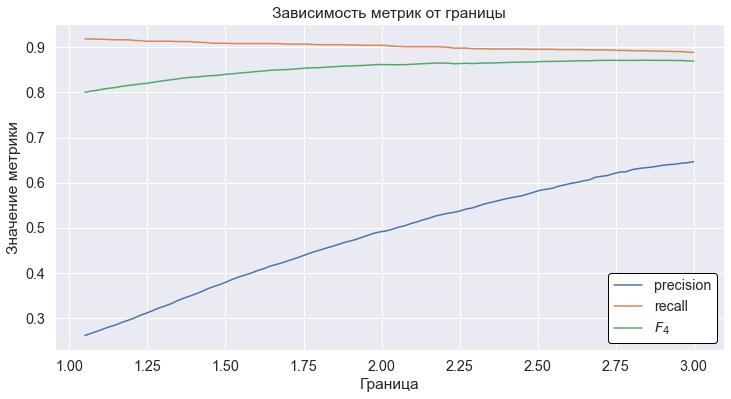

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(margin_borders_exp, precision_values, label='precision')
plt.plot(margin_borders_exp, recall_values, label='recall')
plt.plot(margin_borders_exp, fbeta_values, label='$F_4$')
plt.title('Зависимость метрик от границы')
plt.xlabel('Граница')
plt.ylabel('Значение метрики')
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

Найдем оптимальное значение `margin_border`.

In [27]:
best_idx = np.argmax(fbeta_values)
margin_border_exp_optimal = margin_borders_exp[best_idx]
print(f'Лучший кандидат должен превосходить текущего '
      f'в {margin_border_exp_optimal:.3f} раза')
print(f'Лучшее значение F_4: {fbeta_values[best_idx]:.4f}')
print(f'Соответствующее значение precision: {precision_values[best_idx]:.4f}')
print(f'Соответствующее значение recall: {recall_values[best_idx]:.4f}')

Лучший кандидат должен превосходить текущего в 2.842 раза
Лучшее значение F_4: 0.8712
Соответствующее значение precision: 0.6329
Соответствующее значение recall: 0.8922


Как видим, текущий скор уже выглядит достаточно хорошо, но интересно узнать насколько его можно улучшить.

Проведем также аналогичный эксперимент, но с игнорированием позиций, где слова начинаются с заглавной буквы (за исключением первой позиции).

In [28]:
margin_borders_exp = np.linspace(1.05, 3, 100)
margin_borders = np.log(margin_borders_exp)
precision_values = []
recall_values = []
fbeta_values = []

for margin_border in margin_borders:
    answer = df['answer']
    prediction = (
        (df['margin_kenlm_agg_score'] > margin_border)
        & ~(df['is_title'] & ~df['is_first'])
    )
    precision_values.append(precision_score(answer, prediction))
    recall_values.append(recall_score(answer, prediction))
    fbeta_values.append(fbeta_score(answer, prediction, beta=4))

In [29]:
best_idx = np.argmax(fbeta_values)
margin_border_exp_optimal = margin_borders_exp[best_idx]
print(f'Лучший кандидат должен превосходить текущего '
      f'в {margin_border_exp_optimal:.3f} раза')
print(f'Лучшее значение F_4: {fbeta_values[best_idx]:.4f}')
print(f'Соответствующее значение precision: {precision_values[best_idx]:.4f}')
print(f'Соответствующее значение recall: {recall_values[best_idx]:.4f}')

Лучший кандидат должен превосходить текущего в 2.842 раза
Лучшее значение F_4: 0.8708
Соответствующее значение precision: 0.6498
Соответствующее значение recall: 0.8897


Как видим, стратегия с игнорированием слов, написанных с большой буквы не очень хороша, но учитывать этот признак все же стоит.

### Logistic Regression

Попробуем решать задачу классификации, для каждой позиции предсказывая требует она исправления или нет. Так как нам в дальнейшем потребуется настройка разделяющей плоскости, воспользуемся механизмом взвешивания классов. Опытным путем было получено, что почти оптимально поиском по сетке выйдет взять `class_weight='balanced'`.

In [30]:
def f4_score_func(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=4)

f4_scorer = make_scorer(f4_score_func)

In [31]:
model = Pipeline(
    [('scaler', StandardScaler()), 
     ('log_reg', LogisticRegression(
         random_state=42, class_weight='balanced', solver='liblinear'
     ))]
)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
f4 = cross_val_score(model, X, y, scoring=f4_scorer, cv=kf).mean()
validation_results = cross_validate(
    model, X, y, scoring=['precision', 'recall'], cv=kf
)
precision = validation_results['test_precision'].mean()
recall = validation_results['test_recall'].mean()

In [32]:
print(f'F_4: {f4:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F_4: 0.9397
Precision: 0.7243
Recall: 0.9577


Обучим модель на всех данных и сохраним ее.

In [33]:
model = Pipeline(
    [('scaler', StandardScaler()), 
     ('log_reg', LogisticRegression(
         random_state=42, class_weight='balanced', solver='liblinear'
     ))]
)
model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [34]:
!mkdir -p ../models/position_selector

In [35]:
with open(os.path.join(MODEL_PATH, 'position_selector', 'log_reg.bin'), 'wb') as ouf:
    pickle.dump(model, ouf)

Посмотрим на веса коэффициентов в модели:

In [36]:
for coef, feature_name in zip(model['log_reg'].coef_.ravel(), X.columns.tolist()):
    print(f'{feature_name}: {coef:.3f}')

is_title: 0.164
is_upper: -0.216
is_lower: 0.445
is_first: 0.529
is_title_not_is_first: -0.405
num_candidates: -0.203
is_current_contains_hyphen: -0.061
current_kenlm_left_right_score: -0.947
current_kenlm_right_left_score: -0.940
current_kenlm_agg_score: 0.812
freq_levenshtein_searcher: -0.926
freq_phonetic_searcher: -0.672
freq_handcode_searcher: 2.871
freq_kenlm_left_right_better_current: -0.047
freq_kenlm_right_left_better_current: -0.077
freq_kenlm_agg_better_current: 0.039
margin_kenlm_left_right_score: 1.049
margin_kenlm_right_left_score: 1.116
margin_kenlm_agg_score: 0.430


1. Если в позиции стояло слово, начинающееся с заглавной буквы и не являющееся первым, то мы меньше думаем о том, что в этой позиции стоит делать исправление.
2. Коэффициент перед признаком `is_first` указывает на то, что первое слово имеет смысл исправлять чаще.
3. Коэффициент перед признаком `num_candidates` указывает на то, что если имеем много кандидатов, то, мы с меньшей вероятностью уверены в том, что в этой позиции ошибка. Наверное, если слово написано с ошибкой, то существует меньше способов его изменить, чем слово, написанное без ошибки.
4. Коэффициенты перед скорами kenlm выглядят противоречиво.
5. Видим сильное внимание к модели, если в списке кандидатов есть кандидат из `handcode_searcher`.
6. Видим слабое влияние признаков, отвечающих за частоту, с которой различные кандидаты лучше текущего согласно kenlm.
7. Видим достаточно большую значимость признаков, указывающих на зазор между текущим кандидатом и лучшим согласно kenlm.

### CatBoost

Теперь попробуем обучить модель CatBoost. Для этого сначала придется определить кастомную метрику.

In [37]:
class FBetaCatBoostMetric(object):
    
    def __init__(self, beta):
        self.beta = beta
    
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        pred = approxes[0]
        
        TP = 0
        FP = 0
        FN = 0
        weight_sum = 0 

        for i in range(len(target)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            TP += w * int(pred[i] > 0 and target[i] == 1.0)
            FP += w * int(pred[i] > 0 and target[i] == 0.0)
            FN += w * int(pred[i] <= 0 and target[i] == 1.0)
        
        if TP == 0:
            fbeta = 0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            fbeta = ((1 + self.beta**2) * precision * recall 
                     / (self.beta**2 * precision + recall))
        
        return fbeta, 1.0

In [38]:
classes = np.unique(y)
weights = compute_class_weight(
    class_weight='balanced', classes=classes, y=y
)
class_weights = dict(zip(classes, weights))
params = {
    'eval_metric': FBetaCatBoostMetric(4),
    'random_seed': 42,
    'class_weights': class_weights,
    'verbose': False
}

Посмотрим, чего удастся добиться на hold-out валидации.

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=0
)
pool_train = Pool(X_train, y_train)
pool_val = Pool(X_val, y_val)
model = CatBoostClassifier(**params)
model.fit(pool_train, eval_set=pool_val)

In [40]:
model.tree_count_

1

Как видим, модель переобучается практически мгновенно. Я пробовал разные разбиения на обучение/валидацию и такое происходит довольно часто. Лучше не использовать эту модель, так как слишком велик риск переобучения.

### Decision Tree

Если бустинг переобучается, то можно попробовать посмотреть на простое решающее дерево.

In [41]:
model = tree.DecisionTreeClassifier(
    criterion='gini', random_state=42, max_depth=5, min_samples_leaf=50, 
    class_weight='balanced'
)
f4 = cross_val_score(model, X, y, scoring=f4_scorer, cv=kf).mean()
validation_results = cross_validate(
    model, X, y, scoring=['precision', 'recall'], cv=kf
)
precision = validation_results['test_precision'].mean()
recall = validation_results['test_recall'].mean()

In [42]:
print(f'F_4: {f4:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F_4: 0.9377
Precision: 0.6797
Recall: 0.9609


Как видим, оно дает результаты примерно такого же порядка, что и логистическая регрессия. Можно было выбить и несколько больше, но я бы предпочел большую интерпретируемость в данный момент.

Обучим модель на всех данных и сохраним ее.

In [43]:
model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=50, random_state=42)

In [44]:
with open(os.path.join(MODEL_PATH, 'position_selector', 'tree.bin'), 'wb') as ouf:
    pickle.dump(model, ouf)

Визуализируем модель.

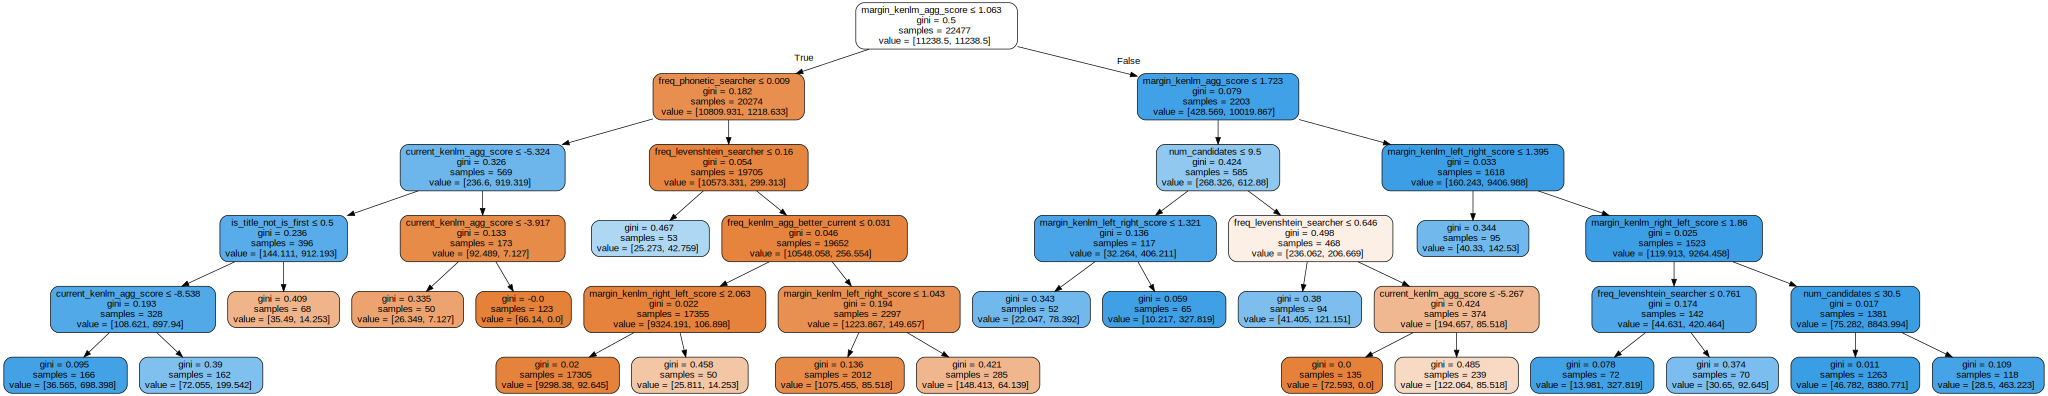

In [45]:
dot_data = tree.export_graphviz(
    model, out_file=None,
    feature_names=X.columns, filled=True, rounded=True, 
    special_characters=True
)
graphviz.Source(dot_data)

In [46]:
for coef, feature_name in zip(model.feature_importances_, X.columns.tolist()):
    print(f'{feature_name}: {coef:.3f}')

is_title: 0.000
is_upper: 0.000
is_lower: 0.000
is_first: 0.000
is_title_not_is_first: 0.003
num_candidates: 0.010
is_current_contains_hyphen: 0.000
current_kenlm_left_right_score: 0.000
current_kenlm_right_left_score: 0.000
current_kenlm_agg_score: 0.015
freq_levenshtein_searcher: 0.010
freq_phonetic_searcher: 0.123
freq_handcode_searcher: 0.000
freq_kenlm_left_right_better_current: 0.000
freq_kenlm_right_left_better_current: 0.000
freq_kenlm_agg_better_current: 0.002
margin_kenlm_left_right_score: 0.004
margin_kenlm_right_left_score: 0.002
margin_kenlm_agg_score: 0.832


1. Видим, что главным признаком является `margin_kenlm_agg_score`, а остальные признаки имеют очень небольшой вклад . Возможно, модель слишком небольшая, чтобы увидеть пользу от них.

## Тестирование модели

Приведем результаты тестирования модели в сравнении с аналогичной моделью со старой версией position selector.

### Обучающая выборка

**Ranking SVM (после изменения position selector)**

* True Positive: $1308$
* Внесенных исправлений: $1460$ 
* Требуемых исправления: $1727$ 
* Precision: $89.59$, доверительный интервал: $(88.03, 91.15)$
* Recall: $75.74$, доверительный интервал: $(74.42, 77.06)$
* FMeasure: $82.01$, доверительный интервал: $(80.65, 83.52)$

**Ranking SVM (до изменения position selector)**

* True Positive: $1311$
* Внесенных исправлений: $1451$ 
* Требуемых исправления: $1727$ 
* Precision: $90.35$, доверительный интервал: $(88.83, 91.87)$
* Recall: $75.91$, доверительный интервал: $(74.63, 77.19)$
* FMeasure: $82.50$, доверительный интервал: $(81.11, 83.90)$

### Тестовая выборка

**Ranking SVM (после изменения position selector)**

* True Positive: $1378$
* Внесенных исправлений: $1584$ 
* Требуемых исправления: $1976$ 
* Precision: $86.99$, доверительный интервал: $(85.34, 88.65)$
* Recall: $69.74$, доверительный интервал: $(68.41, 71.06)$
* FMeasure: $77.42$, доверительный интервал: $(75.94, 78.89)$

**Ranking SVM (до изменения position selector)**

* True Positive: $1393$
* Внесенных исправлений: $1596$ 
* Требуемых исправления: $1976$ 
* Precision: $87.28$, доверительный интервал: $(85.66, 88.91)$
* Recall: $70.50$, доверительный интервал: $(69.18, 71.81)$
* FMeasure: $78.00$, доверительный интервал: $(76.54, 79.45)$

Как видим, в обоих случаях результаты не улучшились. Попробуем это хоть как-то объяснить. Кажется, дело в том, что хоть новая модель и научилась находить больше ошибок, исправить их candidate scorer не может, так как у него просто нет подходящего кандидата. Старая модель же модель выбирает позицию для исправлния только в том случае, если уверена, что может исправить.

## Выводы

1. В этом ноутбуке была собрана обучающая выборка для position selector, который использует другие признаки помимо скоров от kenlm.
2. Было показано, что уже имеющаяся модель, смотрящая только на саггрегированный скор kenlm имеет качество $F_4 \approx 87.1$
3. Была обучена модель логистической регрессии с $F_4 \approx 94.0\%$.
4. В результате тестирования было показано, что этот подход не дает улучшения результата. Также сделана попытка объяснить это.